# $ West Nile Project 4 $
### $ Predicting West Nile in Chicago $
#### Contributors: Will Suh, Ahbishek Sharma, Uday Datta, Jon Lau

In [2]:
!pip install vincenty #measures distance between lat and long

  Running setup.py bdist_wheel for vincenty ... done
  Stored in directory: /Users/jon/Library/Caches/pip/wheels/51/33/73/9b9898fb2becf6a3b3082fc863daeade08ccd8900ea9c947c4
Successfully built vincenty


In [4]:
!pip install imblearn

    100% |████████████████████████████████| 153kB 4.9MB/s ta 0:00:01


In [5]:
import pandas as pd 
import numpy as np
import seaborn as sns

from vincenty import vincenty 
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

import time
from datetime import datetime
%autocall 1

Automatic calling is: Smart


# Importing Datasets




In [6]:
spray = pd.read_csv("./data/west_nile/input/spray.csv")
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [7]:
#weather_file = files.upload()
weather = pd.read_csv('./data/west_nile/input/weather.csv')
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [8]:
#train_file = files.upload()
train = pd.read_csv('./data/west_nile/input/train.csv')
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [9]:
#import Test File
#test_file = files.upload()
test = pd.read_csv('./data/west_nile/input/test.csv')
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


# EDA

In [10]:
def EDA(df):
    null_vals = df.isnull().sum()[df.isnull().sum() > 0] 
    shape = df.shape
    dtypes = df.dtypes
    print('Nulls:', null_vals)
    print('Shape:', shape)
    print('Data Types:', dtypes)

In [11]:
print(EDA(train))
print(EDA(test))
print(EDA(spray))
print(EDA(weather))
#print(EDA(sample))

Nulls: Series([], dtype: int64)
Shape: (10506, 12)
Data Types: Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object
None
Nulls: Series([], dtype: int64)
Shape: (116293, 11)
Data Types: Id                          int64
Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
dtype: object
None
Nulls: Time    584
dtype: int64
Shape: (14835, 4)
Dat

 No np.NaNs in our data. Nulls are represented with M in some fields. 

In [12]:
# date is an object an int
def convert_date(df):
    df['Date'] = pd.to_datetime(df['Date'])

In [13]:
convert_date(train)
convert_date(test)
convert_date(weather)

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


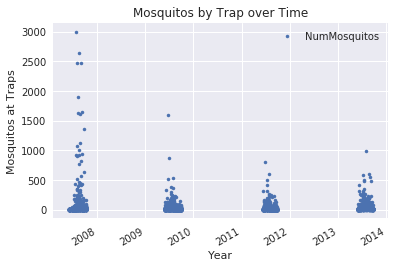

In [14]:
#plotted mosquitos by trap by date
train[['Date', 'Trap', 'NumMosquitos']].groupby(by = ['Date','Trap'])['Date','Trap','NumMosquitos'] \
    .sum().reset_index().sort_values('NumMosquitos', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Mosquitos by Trap over Time')
plt.xlabel('Year')
plt.ylabel('Mosquitos at Traps');

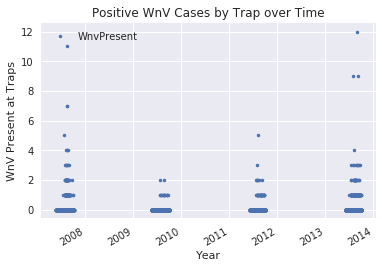

In [15]:
#plotted WNV incidents by trap
train[['Date', 'Trap','WnvPresent']].groupby(by = ['Date','Trap'])['Date','Trap','WnvPresent'] \
    .sum().reset_index().sort_values('WnvPresent', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Positive WnV Cases by Trap over Time')
plt.xlabel('Year')
plt.ylabel('WnV Present at Traps');

Allowing us to visually undestand out timeseries data. 

In [16]:
#Create new column for combined Lat and Long
train['LatLong'] = list(zip(train.Latitude, train.Longitude))
test['LatLong'] = list(zip(test['Latitude'], test['Longitude']))

station1 = (41.995, -87.933)
station2 = (41.786, -87.752)
train['Closest_Station'] = [ 1 if vincenty(x,station1) < vincenty(x,station2) else 2 for x in train['LatLong']]
test['Closest_Station'] = [ 1 if vincenty(x,station1) < vincenty(x,station2) else 2 for x in test['LatLong']]

In [18]:
#Merge DataFramne

train_weather = train.merge(weather,how = 'left', left_on = ['Date','Closest_Station'],right_on =['Date','Station'])
test_weather = test.merge(weather,how = 'left', left_on = ['Date','Closest_Station'],right_on =['Date','Station'])

In [19]:
train_weather = train_weather.drop(columns = ['SeaLevel','CodeSum', 'Sunrise', 'Sunset','Depart','Depth','Water1', 'SnowFall', 'Cool', 'Heat','StnPressure', 'AvgSpeed','ResultSpeed','ResultDir','NumMosquitos'])
test_weather =test_weather.drop(columns = ['SeaLevel','CodeSum', 'Sunrise', 'Sunset','Depart','Depth','Water1', 'SnowFall', 'Cool', 'Heat','StnPressure', 'AvgSpeed','ResultSpeed','ResultDir'])

Dropping columns that we don't se as useful. 

In [20]:
#filling in missing(M) and trace(T)
weather_dataset = train_weather.columns.tolist()

for col in weather_dataset:
    for row in range(train_weather.shape[0]):
        if train_weather.loc[row, col] == 'M' or train_weather.loc[row, col] == '  T':
            train_weather.loc[row, col] = train_weather.loc[row - 1, col]

In [21]:
weather_dataset2 = test_weather.columns.tolist()

for col in weather_dataset2:
    for row in range(test_weather.shape[0]):
        if test_weather.loc[row, col] == 'M' or test_weather.loc[row, col] == '  T':
            test_weather.loc[row, col] = test_weather.loc[row - 1, col]

This fills in the T and M data with closest data. Time series allows us to do this knowing that the data is corrlated. 
This allows the data to be all numerical for modeling. (same for cell below)

In [22]:

weather_object_dtypes = ['Tavg', 'WetBulb', 'PrecipTotal']

for col in weather_object_dtypes:
    train_weather[col] = pd.to_numeric(train_weather[col])
    test_weather[col] = pd.to_numeric(test_weather[col])

In [23]:
def mosquito(df):
    #split wnv transmitting mosquito species lines into separate columns
    df['CULEX PIPIENS'] = 0
    df['CULEX RESTUANS'] = 0
    
    for row in range(df.shape[0]):
        if df.loc[row, 'Species'] == 'CULEX PIPIENS/RESTUANS':
            df.loc[row, 'CULEX PIPIENS'] == 1
            df.loc[row, 'CULEX RESTUANS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX PIPIENS':
            df.loc[row, 'CULEX PIPIENS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX RESTUANS':
            df.loc[row, 'CULEX RESTUANS'] == 1
            
    
    df.drop(columns = ['Species'], inplace = True)

In [24]:
#call function
mosquito(train_weather)
mosquito(test_weather)

In [25]:
train_weather = pd.get_dummies(train_weather, columns = ['Block', 'Trap'])
test_weather = pd.get_dummies(test_weather, columns = ['Block', 'Trap'])

Turning the categorical data into numerical data with function and get dummeies to prepare for modeling. 

In [26]:
# interaction features
train_weather['wet_temp'] = train_weather['PrecipTotal']*train_weather['Tavg']
train_weather['wet_temp_roll'] = train_weather['wet_temp'].rolling(3).mean()
train_weather['wet_temp_roll'].fillna(0, inplace = True)
train_weather['wet_temp_roll_shift14'] = train_weather['wet_temp_roll'].shift(14)
train_weather['wet_temp_roll_shift14'].fillna(0, inplace = True)
train_weather['wet_temp_roll_shift7'] = train_weather['wet_temp_roll'].shift(7)
train_weather['wet_temp_roll_shift7'].fillna(0, inplace = True)


In [27]:
test_weather['wet_temp'] = test_weather['PrecipTotal']*test_weather['Tavg']
test_weather['wet_temp_roll'] = test_weather['wet_temp'].rolling(3).mean()
test_weather['wet_temp_roll'].fillna(0, inplace = True)
test_weather['wet_temp_roll_shift14'] = test_weather['wet_temp_roll'].shift(14)
test_weather['wet_temp_roll_shift14'].fillna(0, inplace = True)
test_weather['wet_temp_roll_shift7'] = test_weather['wet_temp_roll'].shift(7)
test_weather['wet_temp_roll_shift7'].fillna(0, inplace = True)

Creating interactive feature of Temp and Precipation and then doing a rolling 3 day mean. Then also shifting that data 1 and 2 weeks. This gives us one feature to account for best mosquito temps and time shifts it for the hatching and larvea time. 

In [28]:
def date_split(df):
    #breaking week, month, and year into separate columns
    
    df['Week'] = df['Date'].dt.week
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year

    #drop date column
    df.drop(columns = 'Date', inplace = True)

    #get dummies
    return pd.get_dummies(df, columns = ['Week'])
    return pd.get_dummies(df, columns = ['Month'])
    return pd.get_dummies(df, columns = ['Year'])

In [29]:
#call function
date_split(train_weather)
date_split(test_weather)

,Id,Address,Street,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,LatLong,Closest_Station,Station,...,Week_31,Week_32,Week_33,Week_34,Week_35,Week_36,Week_37,Week_38,Week_39,Week_40
0,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,"(41.95469, -87.800991)",1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,"(41.95469, -87.800991)",1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,"(41.95469, -87.800991)",1,1,...,0,0,0,0,0,0,0,0,0,0
3,4,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,"(41.95469, -87.800991)",1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,"(41.95469, -87.800991)",1,1,...,0,0,0,0,0,0,0,0,0,0
5,6,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,"(41.95469, -87.800991)",1,1,...,0,0,0,0,0,0,0,0,0,0
6,7,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,"(41.95469, -87.800991)",1,1,...,0,0,0,0,0,0,0,0,0,0
7,8,"4100 North Oak Park Avenue, Chicago, IL 60634,...",N OAK PARK AVE,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,"(41.95469, -87.800991)",1,1,...,0,0,0,0,0,0,0,0,0,0
8,9,"6200 North Mandell Avenue, Chicago, IL 60646, USA",N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,"(41.994991, -87.769279)",1,1,...,0,0,0,0,0,0,0,0,0,0
9,10,"6200 North Mandell Avenue, Chicago, IL 60646, USA",N MANDELL AVE,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,"(41.994991, -87.769279)",1,1,...,0,0,0,0,0,0,0,0,0,0


<BarContainer object of 7 artists>

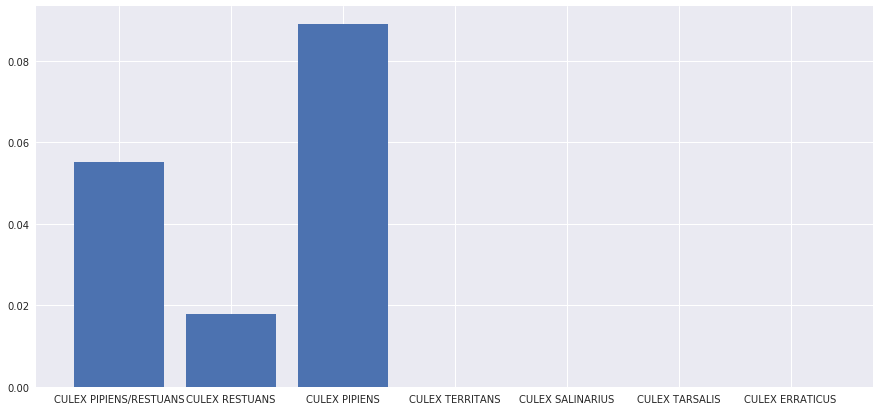

In [30]:
# Plotting out WNV Present by Species
grouped = train.groupby(["Species"])
grouped_percentage = pd.DataFrame()
grouped_percentage["Number of Total Instances"] = train["Species"].value_counts()
grouped_percentage["WnvNotPresent Rate"] = grouped["WnvPresent"].apply(lambda x : x.value_counts()[0]/len(x) )
grouped_percentage["WnvPresent Rate"] = 1 - grouped_percentage["WnvNotPresent Rate"]
grouped_percentage["WnvNotPresent Instances"] = grouped_percentage["Number of Total Instances"] * grouped_percentage["WnvNotPresent Rate"]
grouped_percentage["WnvPresent Instances"] = grouped_percentage["Number of Total Instances"] - grouped_percentage["WnvNotPresent Instances"]

#grouped_percentage

plt.figure(figsize=(15,7))
plt.bar(grouped_percentage.index ,grouped_percentage["WnvPresent Rate"])

In [31]:
train_weather.drop(columns = ['Address','Street', 'AddressNumberAndStreet', 'Latitude', \
                                              'Longitude', 'AddressAccuracy','LatLong'], inplace = True)
test_weather.drop(columns = ['Address','Street', 'AddressNumberAndStreet', 'Latitude', \
                                              'Longitude', 'AddressAccuracy','LatLong'], inplace = True)

Removing some columns that are not needed for modeling. Block get dummies covers a lot of this data.

In [32]:
# Train-Train-Split on Data Set

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
X = train_weather.drop('WnvPresent', axis =1)
y = train_weather['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


In [33]:
traindata = X_train.merge(pd.DataFrame(y_train), how = 'left', right_index = True, left_index = True)
train_majority = traindata[traindata['WnvPresent'] == 0]
train_minority = traindata[traindata['WnvPresent'] == 1]
train_minority_upsampled = resample(train_minority, 
                                     replace = True, 
                                     n_samples = train_majority.shape[0],
                                     random_state = 42)

train_data_upsampled = pd.concat([train_majority, train_minority_upsampled])
X_train = train_data_upsampled.drop(columns = 'WnvPresent')
y_train = train_data_upsampled['WnvPresent']

In [34]:
def drop_columns(df1, df2):
    #drop columns in either test/train that are not in the other
    
    df1cols = df1.columns.tolist()
    df2cols = df2.columns.tolist()
    
    notindf1cols = []
    notindf2cols = []
    
    for col in df1cols:
        if col not in df2cols:
            notindf2cols.append(col)
    
    for col in df2cols:
        if col not in df1cols:
            notindf1cols.append(col)
            
    df1.drop(columns = notindf2cols, inplace = True)
    df2.drop(columns = notindf1cols, inplace = True)

In [35]:
drop_columns(test_weather, train_weather)


Making sure our Train and Test data is aligned. 

In [36]:
#checking Class Balance
y_train.value_counts()

1    7466
0    7466
Name: WnvPresent, dtype: int64

In [41]:
# RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = RandomForestClassifier()

rf_pipe = Pipeline([
    #('ss', ss),
    ('rf', rf)
])

params = {'rf__n_estimators' : [150,200,250,300],
          'rf__max_depth' : [None, 2, 3, 4, 5]}

rf_gs = GridSearchCV(rf_pipe, param_grid=params, cv=5, scoring='roc_auc',n_jobs= 5)
rf_gs.fit(X_train, y_train)

best_rf_gs = rf_gs.best_estimator_

rf_gs_train = best_rf_gs.score(X_train, y_train)
rf_gs_test = best_rf_gs.score(X_test, y_test)

print(best_rf_gs)
print(rf_gs_train)
print(rf_gs_test)
print(rf_gs.best_params_)

Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
0.9608223948566836
0.877426722497145
{'rf__max_depth': None, 'rf__n_estimators': 300}


Used above GS to determine best params to run on Random Forest below

In [42]:
rf = RandomForestClassifier(n_estimators= 300)
rf.fit(X_train,y_train)
rf.score(X_test, y_test)


0.8797106966121051

Text(0.5, 1.0, 'Random Forest Feature Importances')

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


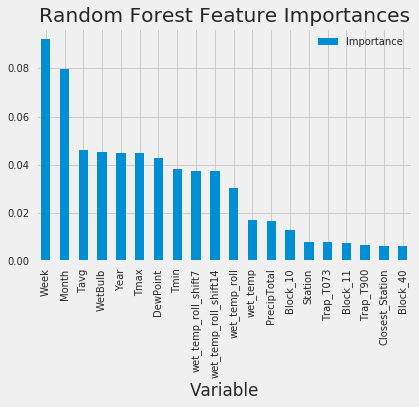

In [43]:
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')



test_names = X.columns.tolist()
rf_importances = pd.DataFrame(sorted(zip(test_names, rf.feature_importances_), reverse = True), columns = ['Variable', 'Importance']).set_index('Variable')
rf_importances.sort_values(by = 'Importance', ascending = False).iloc[:20,:].plot(kind = 'bar')
plt.title('Random Forest Feature Importances')

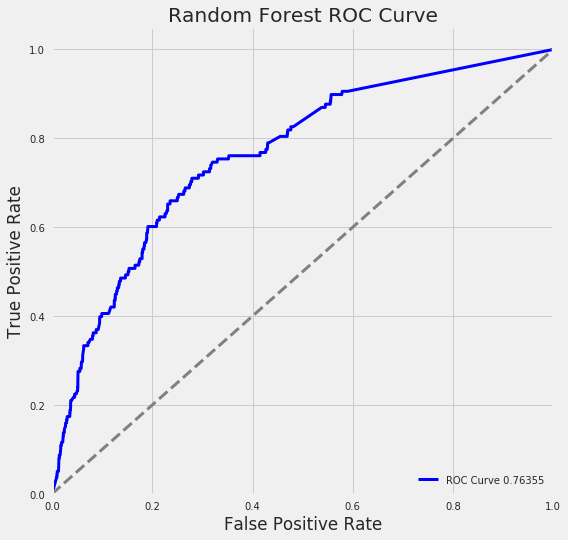

In [44]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8,8))
plt.plot(fpr,tpr,lw = 3, color='blue', label='ROC Curve %.5f' % auc)
plt.plot([0,1], [0,1], lw = 3, linestyle ='--', color='grey')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.savefig('gbc_roc.png')
plt.show()

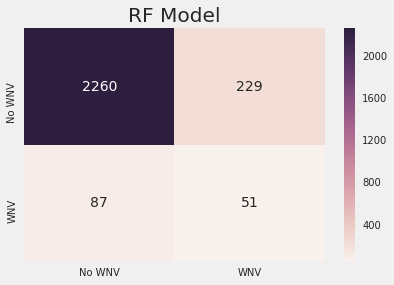

In [45]:
from sklearn.metrics import confusion_matrix
# Create a heatmap confusion matrix - get predictions 
predictions = rf.predict(X_test)

# Create confusion matrix 
classes = ["No WNV", 'WNV']
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, columns=classes)
cm.index = classes

# Plot matrix on heatmap 
sns.heatmap(cm, annot=True, fmt='g')
plt.title('RF Model');


In [46]:
# ADABoost
from sklearn.ensemble import AdaBoostClassifier

adamodel = AdaBoostClassifier(n_estimators=100) 
ada_scores = cross_val_score(adamodel, X_train, y_train, cv=5)
adamodel.fit(X_train,y_train)
adamodel.score(X_train,y_train)
y_preds = adamodel.predict(X_test)
adamodel.score(X_test,y_test)

0.75142748382185

In [47]:
roc_auc_score(y_test,y_preds)

0.7387752487757728

Text(0.5, 1.0, 'Ada Boost Feature Importances')

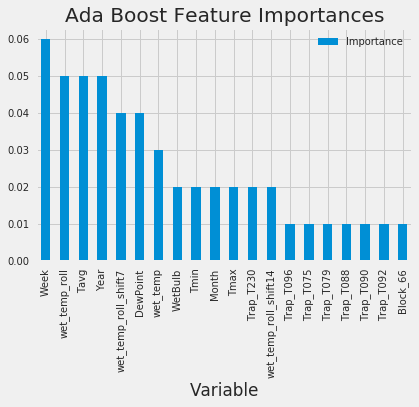

In [48]:
ada_importances = pd.DataFrame(sorted(zip(test_names, adamodel.feature_importances_), reverse = True), columns = ['Variable', 'Importance']).set_index('Variable')
ada_importances.sort_values(by = 'Importance', ascending = False).iloc[:20,:].plot(kind = 'bar')
plt.title('Ada Boost Feature Importances')

In [49]:
adapredicts = pd.DataFrame(y_preds, columns = ['predict'])
#adapredicts.columns
adapredicts['predict'].value_counts()

0    1912
1     715
Name: predict, dtype: int64

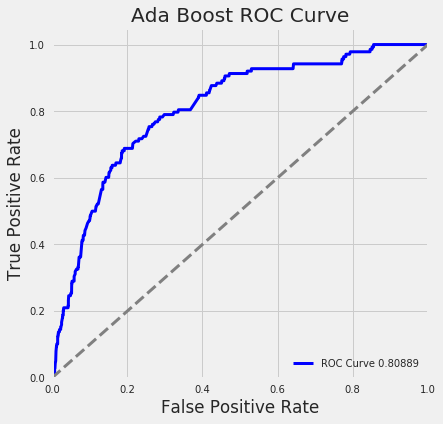

In [50]:
y_pred_proba = adamodel.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,lw = 3, color='blue', label='ROC Curve %.5f' % auc)
plt.plot([0,1], [0,1], lw = 3, linestyle ='--', color='grey')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ada Boost ROC Curve')
plt.show()

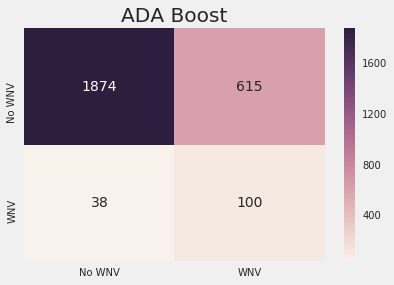

In [51]:
from sklearn.metrics import confusion_matrix
# Create a heatmap confusion matrix - get predictions 
predictions = adamodel.predict(X_test)

# Create confusion matrix 
classes = ["No WNV", 'WNV']
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, columns=classes)
cm.index = classes

# Plot matrix on heatmap 
sns.heatmap(cm, annot=True, fmt='g')
plt.title('ADA Boost');

In [52]:
# XGBoost Classifier (This takes about 5 min to finish)

gs_params = {
    'max_depth':[1, 2, 3, 4, 5],
    'n_estimators':range(1, 10, 1),
    'learning_rate':np.logspace(-5,0,5),
    'silent' : [False],
    'booster' : ['gbtree', 'gblinear', 'dart'] 
}

xgb_gs = GridSearchCV(XGBClassifier(), gs_params, cv=5, verbose=1, scoring='roc_auc',n_jobs = -1)

xgb_gs = xgb_gs.fit(X_train, y_train)

best_xgb_gs = xgb_gs.best_estimator_

xgb_gs_train = best_xgb_gs.score(X_train, y_train)
xgb_gs_test = best_xgb_gs.score(X_test, y_test)

print(best_xgb_gs)
print(xgb_gs_train)
print(xgb_gs_test)

Fitting 5 folds for each of 675 candidates, totalling 3375 fits
[16:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:54] src/tree/updater_prune.cc:74: tree pr

[16:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:10:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s


[16:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2


[16:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:11:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:11:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:11:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:12:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min


[16:12:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:12:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:12:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:12:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:12:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:13:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:13:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.2min


[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:14:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:14:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:15:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:15:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:15:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:15:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=

[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:16:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:16:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:16:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth

[16:16:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.6min


[16:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:16:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:16:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:16:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

[16:17:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:17:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:17:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:17:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:17:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:17:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:17:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:17:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:17:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:17:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_

[16:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[16:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1


[16:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:17:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[

[16:17:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:17:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[

[16:18:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[16:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[16:18:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:18:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_

[16:18:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:18:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:18:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:18:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:18:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:18:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:18:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:18:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:18:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

[16:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[16:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[16:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[16:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[16:18:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[16:18:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[16:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[16:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[16:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[16:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

[16:18:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[16:18:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:18:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:18:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_

[16:19:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:19:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[16:19:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:19:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:19:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:19:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:19:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:19:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[16:19:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_

[16:19:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[16:19:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[16:19:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[16:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[16:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[16:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[16:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[16:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[16:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[16:19:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5


[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 10.5min


[16:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:41] src/gbm/gbtree.cc:494: drop 

[16:22:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:47] src/gbm/gbtree.cc:494: drop 

[16:22:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:22:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:22:51] src/gbm/gbtree.cc:494: drop 

[16:22:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:22:59] src/gbm/gbtree.cc:494: drop 

[16:23:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:06] src/gbm/gbtree.cc:494: drop 

[16:23:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:23:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 prune

[16:23:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 

[16:23:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:20] src/gbm/gbtree.cc:494:

[16:23:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 

[16:23:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 

[16:23:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:23:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 

[16:23:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 

[16:23:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 

[16:23:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 

[16:23:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:23:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:23:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 

[16:24:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 

[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 13.2min


[16:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:05] src/gbm/gbtree.cc:494:

[16:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:12] src/gbm/gbtree.cc:494:

[16:24:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:19] src/gbm/gbtree.cc:494:

[16:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:25] src/gbm/gbtree.cc:494:

[16:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:31] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:24:31] src/gbm/gbtree.cc:494: d

[16:24:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:39] src/gbm/gbtree.cc:494: drop 

[16:24:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:24:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:43] src/gbm/gbtree.cc:494: drop 

[16:24:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:48] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:52] src/gbm/gbtree.cc:494: drop 

[16:24:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:24:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:00] src/gbm/gbtree.cc:494: drop 

[16:25:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:25:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:09] src/gbm/gbtree.cc:494:

[16:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:15] src/gbm/gbtree.cc:494:

[16:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:19] src/gbm/gbtree.cc:494:

[16:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:24] src/gbm/gbtree.cc:494:

[16:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:25:29] src/gbm/gbtree.cc:494:

[16:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:36] src/gbm/gbtree.cc:494:

[16:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:42] src/gbm/gbtree.cc:494:

[16:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:48] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:48] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:48] src/gbm/gbtree.cc:494:

[16:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:25:53] src/gbm/gbtree.cc:494:

[16:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:25:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:01] src/gbm/gbtree.cc:494:

[16:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:08] src/gbm/gbtree.cc:494:

[16:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:15] src/gbm/gbtree.cc:494:

[16:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:21] src/gbm/gbtree.cc:494:

[16:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:28] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:26:28] src/gbm/gbtree.cc:494:

[16:26:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:33] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:36] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:36] src/gbm/gbtree.cc:494: drop 

[16:26:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:26:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:26:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:44] src/gbm/gbtree.cc:494: drop 

[16:26:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:53] src/tree/updater_prune.cc:74

[16:26:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:26:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:26:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:27:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:27:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:27:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:27:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:27:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:27:00] src/gbm/gbtree.cc:494: drop 

[16:27:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:06] src/tree/updater

[16:27:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:10] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:11] src/gbm/gbtree.cc:494:

[16:27:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 

[16:27:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 

[16:27:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:27:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 

[16:27:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 

[16:27:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 

[16:27:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 

[16:27:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 

[16:27:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:27:51] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 

[16:27:57] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:27:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:27:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:27:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:27:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:27:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 

[16:28:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:05] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 

[16:28:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:11] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 

[16:28:17] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 

[16:28:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:28:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 prune

[16:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:27] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:27] src/gbm/gbtree.cc:494: drop 

[16:28:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:32] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:32] src/gbm/gbtree.cc:494: drop 

[16:28:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:28:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:38] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:39] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:39] src/gbm/gbtree.cc:494: drop 

[16:28:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:42] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:46] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:46] src/gbm/gbtree.cc:494: drop 

[16:28:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:49] src/gbm/gbtree.cc:494: drop 

[16:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:28:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:52] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:28:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:28:53] src/gbm/gbtree.cc:494: dro

[16:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:28:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:28:58] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:28:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:28:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:28:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:28:59] src/gbm/gbtree.cc:494:

[16:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:04] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:04] src/gbm/gbtree.cc:494:

[16:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:08] src/gbm/gbtree.cc:494:

[16:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:29:12] src/gbm/gbtree.cc:494:

[16:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:17] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:17] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:17] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:18] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:18] src/gbm/gbtree.cc:494:

[16:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:23] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:24] src/gbm/gbtree.cc:494:

[16:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:29:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:30] src/gbm/gbtree.cc:494:

[16:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:29:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:35] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:35] src/gbm/gbtree.cc:494:

[16:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:29:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:29:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:29:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:29:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:29:40] src/gbm/gbtree.cc:494:

[16:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:29:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:29:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:29:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:29:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:29:47] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:29:47] src/gbm/gbtree.cc:494:

[16:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:29:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:29:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:29:53] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:29:54] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:29:54] src/gbm/gbtree.cc:494:

[16:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:30:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:30:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:30:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:30:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[16:30:00] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:30:00] src/gbm/gbtree.cc:494:

[16:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[16:30:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:30:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:30:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:30:06] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[16:30:07] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:30:07] src/gbm/gbtree.cc:494:

[16:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:30:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[16:30:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:30:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[16:30:12] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:12] src/gbm/gbtree.cc:494: d

[16:30:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:16] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:19] src/gbm/gbtree.cc:494: drop 

[16:30:21] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:22] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:24] src/gbm/gbtree.cc:494: drop 

[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 19.5min


[16:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:30:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned

[16:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:30] src/gbm/gbtree.cc:494: drop 

[16:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:34] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:37] src/gbm/gbtree.cc:494: drop 

[16:30:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:40] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:30:41] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned

[16:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:45] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:45] src/gbm/gbtree.cc:494:

[16:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:30:50] src/gbm/gbtree.cc:494:

[16:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:54] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:54] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:30:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:30:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:30:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:55] src/gbm/gbtree.cc:494:

[16:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:30:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:30:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:59] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:30:59] src/gbm/gbtree.cc:494:

[16:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[16:31:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:31:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:31:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:31:03] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[16:31:03] src/gbm/gbtree.cc:494:

[16:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:31:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[16:31:08] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:31:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[16:31:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:31:09] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[16:31:09] src/gbm/gbtree.cc:494:

[16:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:31:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[16:31:14] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:31:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[16:31:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:31:15] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:31:15] src/gbm/gbtree.cc:494:

[16:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[16:31:19] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:31:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[16:31:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:31:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[16:31:20] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[16:31:20] src/gbm/gbtree.cc:494:

[16:31:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[16:31:24] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[16:31:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[16:31:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[16:31:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[16:31:25] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:31:25] src/gbm/gbtree.cc:494:

[16:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[16:31:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[16:31:29] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:31:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:31:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[16:31:30] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[16:31:30] src/gbm/gbtree.cc:494:

[16:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:31:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[16:31:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:31:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:31:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[16:31:37] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:31:37] src/gbm/gbtree.cc:494:

[16:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:31:43] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:31:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:31:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:31:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[16:31:44] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:31:44] src/gbm/gbtree.cc:494:

[16:31:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:31:49] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:31:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[16:31:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:31:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[16:31:50] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:31:50] src/gbm/gbtree.cc:494:

[16:31:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:31:55] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[16:31:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[16:31:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[16:31:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[16:31:56] src/gbm/gbtree.cc:494: drop 0 trees, weight = 1
[16:31:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[16:31:56] src/gbm/gbtree.cc:494:

[Parallel(n_jobs=-1)]: Done 3375 out of 3375 | elapsed: 21.1min finished


[16:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[16:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[16:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[16:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[16:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[16:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[16:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[16:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[16:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [53]:
# Gridsearch on logistic regression model above
lr_params = {'penalty':['l1', 'l2'], 
             'C': np.logspace(-5, 2, 10)}
gslr = GridSearchCV(LogisticRegression(), param_grid = lr_params)
gslr.fit(X_train, y_train)

# Results 
gslr.best_score_, gslr.best_params_

(0.743570854540584, {'C': 100.0, 'penalty': 'l2'})

In [54]:
gslr.score(X_test,y_test)

0.6619718309859155

In [55]:
lrpredict = gslr.predict(X_test)
roc_auc_score(y_test, lrpredict)

0.6573444896675809

Text(0.5, 1.0, 'Logistic Regression Coefficients')

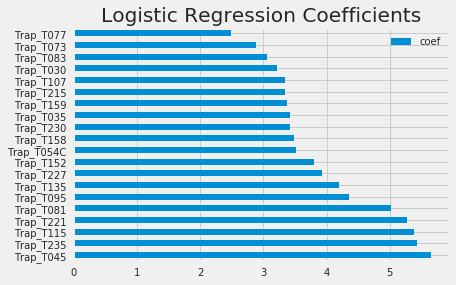

In [56]:
coefs = pd.DataFrame(gslr.best_estimator_.coef_[0], index = X.columns, columns = ['coef'])
coefs.sort_values(by='coef', ascending = False, inplace=True)
coefs.head(20).plot(kind = 'barh')
plt.title('Logistic Regression Coefficients')

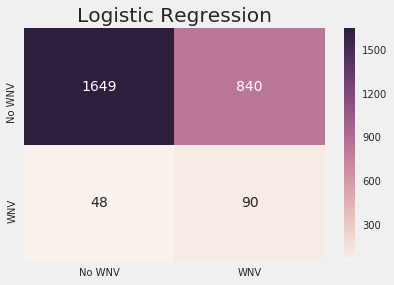

In [57]:
# Create a heatmap confusion matrix - get predictions 
predictions = gslr.predict(X_test)

# Create confusion matrix 
classes = ["No WNV", 'WNV']
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, columns=classes)
cm.index = classes

# Plot matrix on heatmap 
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Logistic Regression');

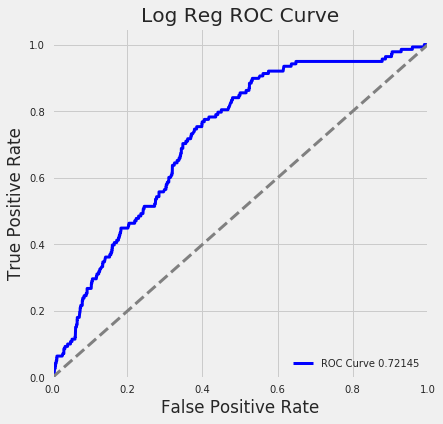

In [58]:
y_pred_proba = gslr.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,lw = 3, color='blue', label='ROC Curve %.5f' % auc)
plt.plot([0,1], [0,1], lw = 3, linestyle ='--', color='grey')
plt.legend(loc=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Reg ROC Curve')
plt.show()

In [60]:
# Executive Summary of Models

print('GridSearchCV across Random Forest:')
print(f"Best Parameters = {rf_gs.best_params_}")
print(f"Best CV Score = {rf_gs.best_score_}")
print(f"Train Score = {rf_gs_train}")
print(f"Test Score = {rf_gs_test}")
print()
print('GridSearchCV across XGBoost:')
print(f"Best Parameters = {xgb_gs.best_params_}")
print(f"Best CV Score = {xgb_gs.best_score_}")
print(f"Train Score = {xgb_gs_train}")
print(f"Test Score = {xgb_gs_test}")



GridSearchCV across Random Forest:
Best Parameters = {'rf__max_depth': None, 'rf__n_estimators': 300}
Best CV Score = 0.9783865747010747
Train Score = 0.9608223948566836
Test Score = 0.877426722497145

GridSearchCV across XGBoost:
Best Parameters = {'booster': 'gbtree', 'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 9, 'silent': False}
Best CV Score = 0.9030226931689402
Train Score = 0.8519957139030271
Test Score = 0.7658926532165968


We picked ADAboost as it optimized for False Negatives. 

In [61]:
predict = adamodel.predict(test_weather)

In [ ]:


test['WnvPresent'] = predict
test[['Id','WnvPresent']].to_csv('submission.csv',index = False)